In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import find_peaks
import scipy.io as sio
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]


sys.path.append("gpib_instrument_control/")
import lmx2594cmd
import gpib_instrument_control.hp_8569b
import gpib_instrument_control.hp_5340a
import gpib_instrument_control.pm_1038
import gpib_instrument_control.hp_3478a
import gpib_instrument_control.wiltron_6659a


sp = gpib_instrument_control.hp_8569b.Hp8569B()
counter=gpib_instrument_control.hp_5340a.Hp5340A()
powBMeter=gpib_instrument_control.hp_3478a.Hp3478A()
pm=gpib_instrument_control.pm_1038.Pm1038(None, powBMeter, bChannelProbeCorrectionFileName='pm11-0674_correctionFactors.mat')
gen=gpib_instrument_control.wiltron_6659a.Wiltron6659A()

lmx = lmx2594cmd.Lmx2594('/dev/ttyUSB0', 320e6)
lmx.enableLockDetect(True)
lmx.setField('OUTA_PWR', 10)
lmx.setField('OUTB_PWR', 63)

Created LMX object wit fosc 320.0
Resetting LMX
Applying config
PRE DIVIDER 2
REF MULT 1
Is locked:  True
FPD is 160.000000 MHz


In [2]:
def rowStack(mtx, vec):
    if mtx is None:
        mtx=np.array(((vec)))
    else:
        mtx=np.row_stack((mtx, vec))
    return mtx

def mtxStack(mtx, vec):
    if mtx is None:
        mtx=np.array(((vec)))
    else:
        mtx=np.dstack((mtx, vec))
    return mtx

def waitForFrequencyToStablizie(approxFrequency):
        rate=2e6;
        mt=0.1;
        f0=counter.readValue()
        t0=time.time();
        for i in range(100):
            time.sleep(mt)
            f=counter.readValue()
            if abs(f-f0)/mt < rate and abs(f-approxFrequency) < 200e6 and f != f0:
                break
            f0=f
        else:
            print("WARNING: Frequency did not stabilize")
        return f
        #print("Frequency stabilized after", time.time()-t0, "Seconds")

def waitForLock(approxFreq):
    for i in range(100):
        time.sleep(0.1)
        if abs(counter.readValue() - approxFreq) < 200e6:
            break
    else:
        print("WARNING, counter is not locked")
    print("locked", counter.readValue()/1e6)
    
        
def sweepLoRf(fif, rfs, tol=40e6, harmonic=1):
    #tol=40e6;
    peaks=[]
    pin=[]
    spectrums=None
    for rf in rfs:
        #flo=np.abs(rfs+fif)
        gen.setCwFreq(rf)
        time.sleep(0.5)
        #waitForLock(rf)
        rfReal=waitForFrequencyToStablizie(rf)
        #rfReal=counter.readValue()
        flo=np.abs(rfReal+fif)/harmonic
        if flo < 20e6:
            flo=20e6
        #print(rf/1e6, rfReal/1e6)
        
        lmx.setFrequency(flo)
        sp.updateTrace()
        fax, p = sp.readTrace()
        fax=np.array(fax)
        p=np.array(p)
        spectrums = rowStack(spectrums, p)
        #print(fax)
        indices = np.where(np.logical_and(fax>np.abs(fif)-tol, fax < np.abs(fif)+tol))[0]
        #print(tol, indices, fif)
        peaks.append(np.max(p[indices]))
        pin.append((pm.readChannelB(rfReal)-18))
        #print(p[indices])
        #print(fax[indices])
    return peaks, pin, spectrums, fax
        
def measureIfFrequency(fif, rfs, plot=True):
    peaks, pin = sweepLoRf(fif, rfs)
    if plot:
        plt.plot(rfs, peaks, label='output')
        plt.plot(rfs, pin, label='input')
        plt.grid(True)
        plt.legend()
    return peaks, pin, rfs       

def mixerCharacterization(ifs, rfs, mixerName, tol=40e6, harmonic=1):
    peakMtx=None
    pinMtx=None
    lossMtx=None
    spectrumCube=None
    for fif in ifs:
        peaks, inputs, spectrums, fax = sweepLoRf(fif, rfs, tol=tol, harmonic=harmonic)
        loss = np.array(inputs)-np.array(peaks)
        peakMtx=rowStack(peakMtx, peaks)
        pinMtx=rowStack(pinMtx, inputs)
        lossMtx=rowStack(lossMtx, loss)
        spectrumCube=mtxStack(spectrumCube, spectrums)
        #plt.plot(rfs, peaks, label=f'if %.2e [Hz]'%(fif))
        #plt.plot(rfs, inputs, label=f'pin %.2e [Hz]'%(fif))
        plt.plot(rfs, loss, label=f'IF %.2e [Hz]'%(fif))
    
    plt.grid(True)
    plt.xlabel('RF frequency [Hz]')
    plt.ylabel('Mixer loss [dB]')
    plt.title(f'Measurement of Mixer %s with average input power %.2f [dBm]'%(mixerName, np.mean(pinMtx)))
    plt.legend()
    saveDict={'peak':peakMtx, 'pin':pinMtx, 'loss':lossMtx, 'spectrum': spectrumCube, 'fax':fax, 'ifs':ifs, 'rfs':rfs}
    sio.savemat(mixerName+'.mat', saveDict)

## MACOM MZ9310C

### LO > RF

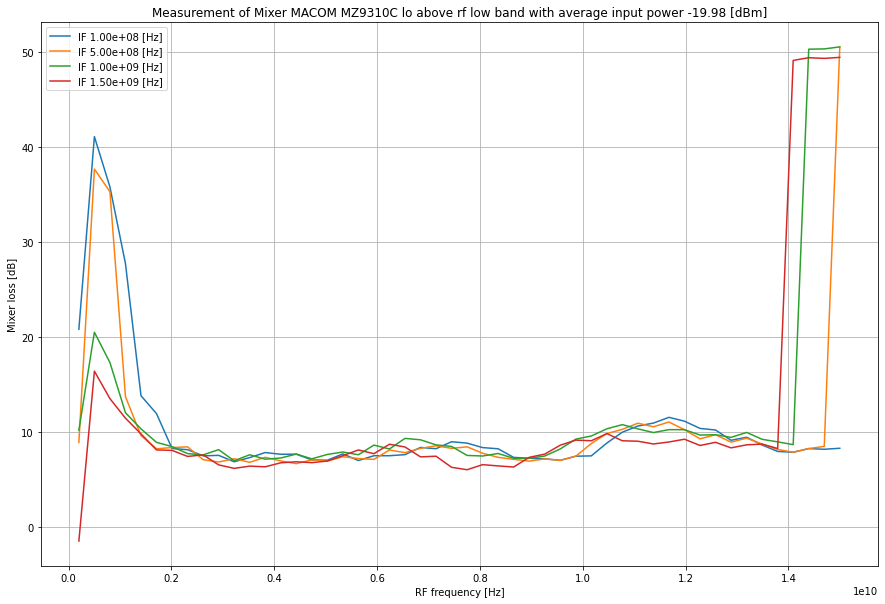

In [29]:
fifs=[100e6, 500e6, 1000e6, 1500e6]
frfs=np.linspace(200e6, 15e9, 50)
mixerCharacterization(fifs, frfs, 'MACOM MZ9310C lo above rf low band')

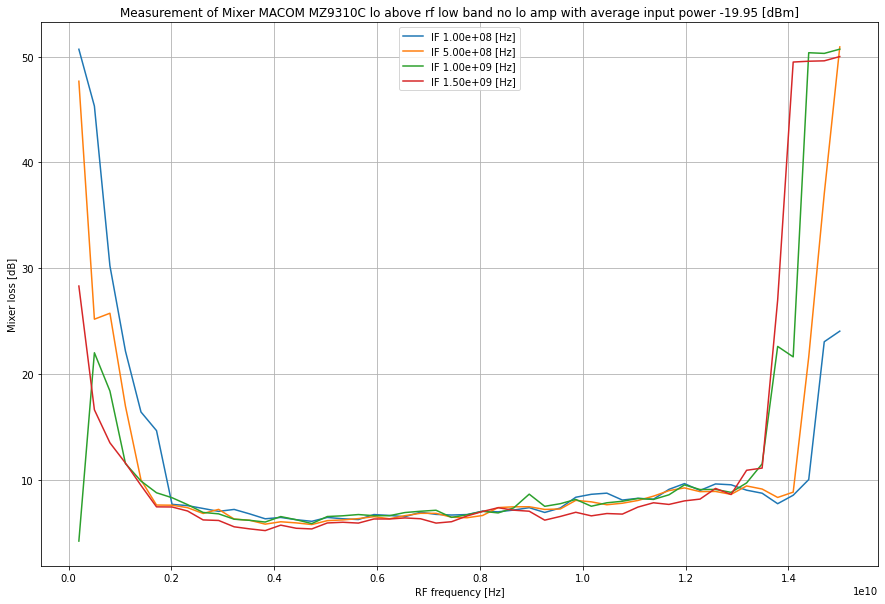

In [7]:
fifs=[100e6, 500e6, 1000e6, 1500e6]
frfs=np.linspace(200e6, 15e9, 50)
mixerCharacterization(fifs, frfs, 'MACOM MZ9310C lo above rf low band no lo amp')

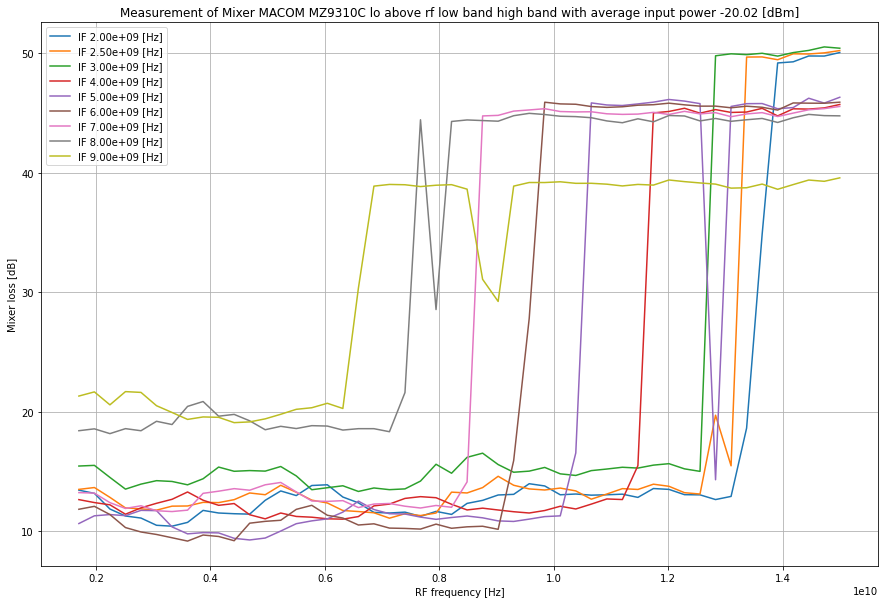

In [33]:
fifs=[2e9, 2.5e9, 3e9, 4e9, 5e9, 6e9, 7e9, 8e9, 9e9]
frfs=np.linspace(1700e6, 15e9, 50)
mixerCharacterization(fifs, frfs, 'MACOM MZ9310C lo above rf low band high band', tol=200e6)

### LO < RF

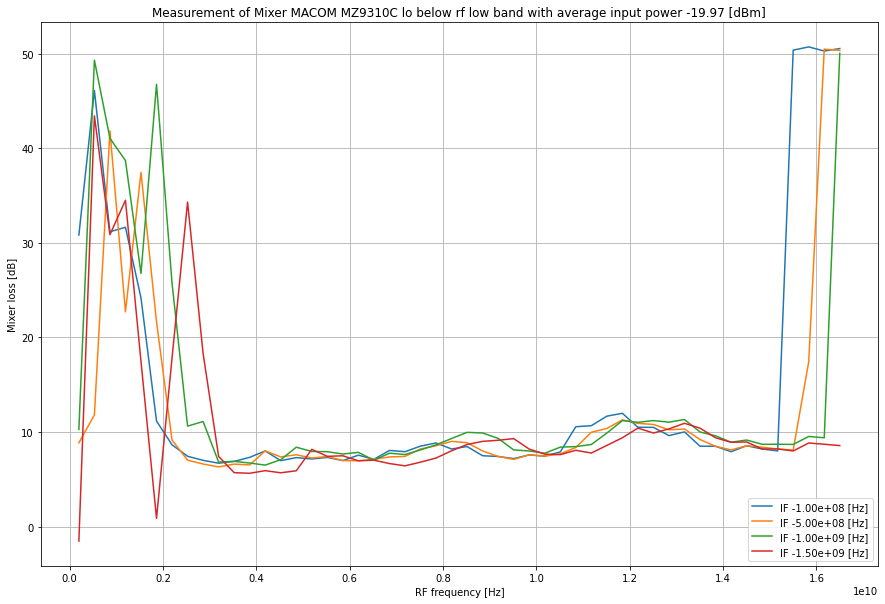

In [32]:
fifs=[-100e6, -500e6, -1000e6, -1500e6]
frfs=np.linspace(200e6, 15e9-np.min(fifs), 50)
mixerCharacterization(fifs, frfs, 'MACOM MZ9310C lo below rf low band')

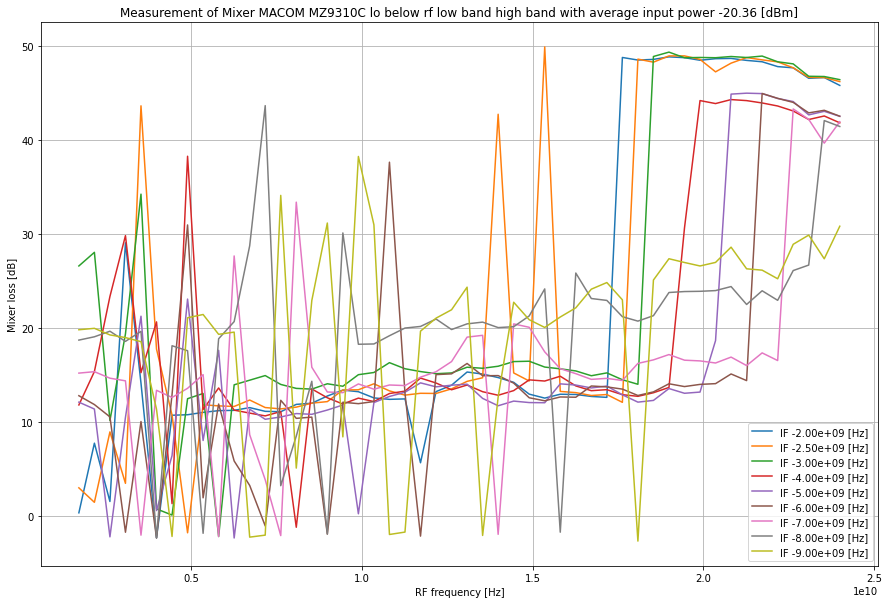

In [34]:
fifs=[-2e9, -2.5e9, -3e9, -4e9, -5e9, -6e9, -7e9, -8e9, -9e9]
frfs=np.linspace(1700e6, 24e9, 50)
mixerCharacterization(fifs, frfs, 'MACOM MZ9310C lo below rf low band high band', tol=200e6)

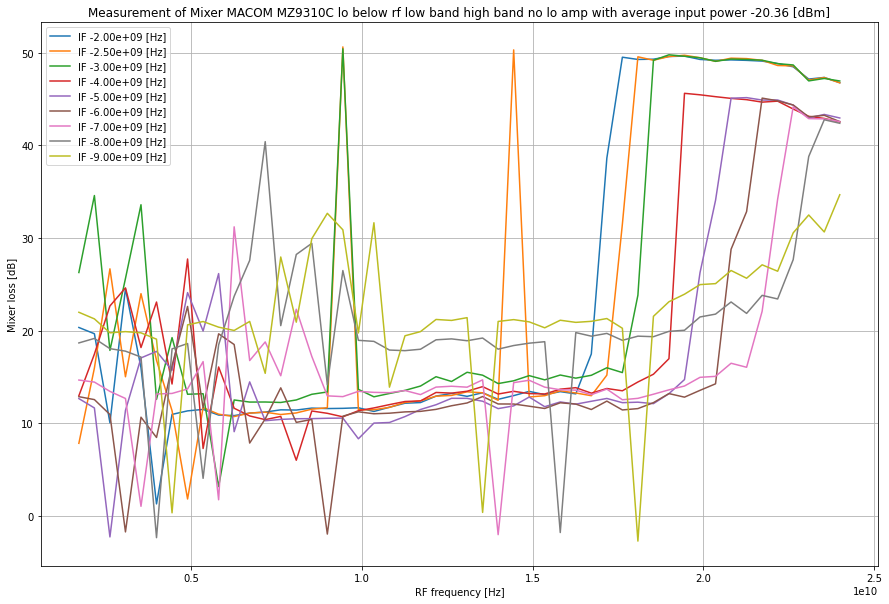

In [9]:
fifs=[-2e9, -2.5e9, -3e9, -4e9, -5e9, -6e9, -7e9, -8e9, -9e9]
frfs=np.linspace(1700e6, 24e9, 50)
mixerCharacterization(fifs, frfs, 'MACOM MZ9310C lo below rf low band high band no lo amp', tol=200e6)

### Harmonics

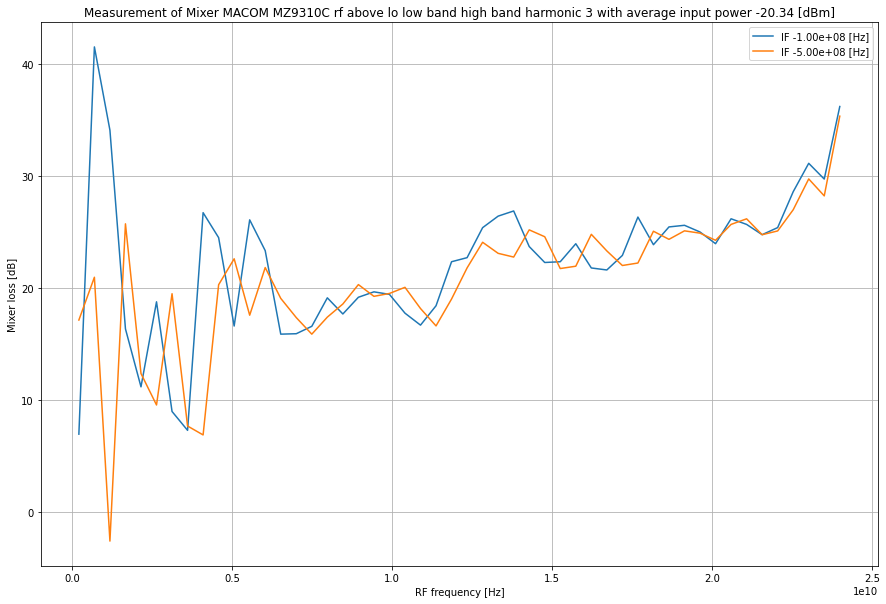

In [12]:
fifs=[-100e6, -250e6, -500e6, -750e6, -800e6, -900e6, -1000e6]
fifs=[-100e6,  -500e6]
frfs=np.linspace(200e6, 24e9, 50)
mixerCharacterization(fifs, frfs, 'MACOM MZ9310C rf above lo low band high band harmonic 3', harmonic=3)

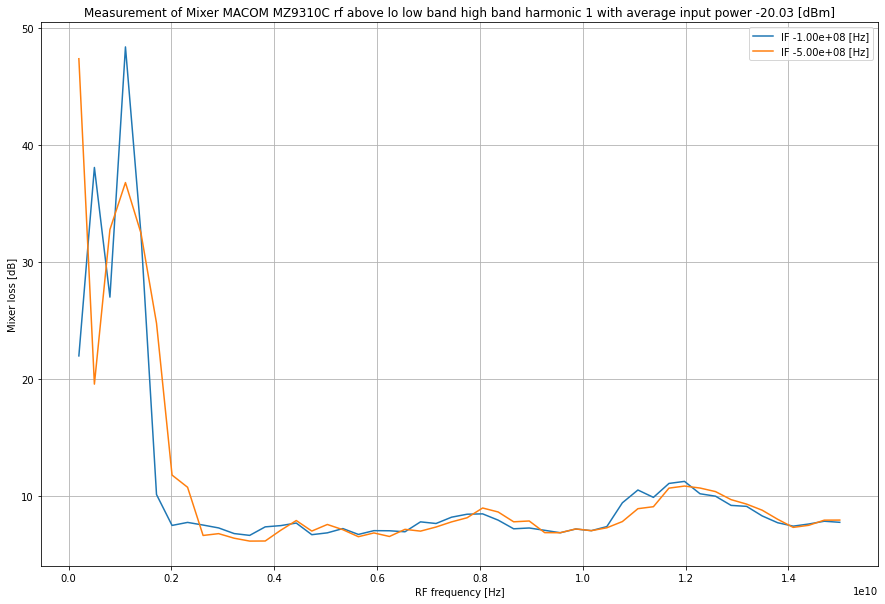

In [13]:
fifs=[-100e6, -250e6, -500e6, -750e6, -800e6, -900e6, -1000e6]
fifs=[-100e6,  -500e6]
frfs=np.linspace(200e6, 15e9, 50)
mixerCharacterization(fifs, frfs, 'MACOM MZ9310C rf above lo low band high band harmonic 1', harmonic=1)

## Ferranti XMM302

### LO > RF

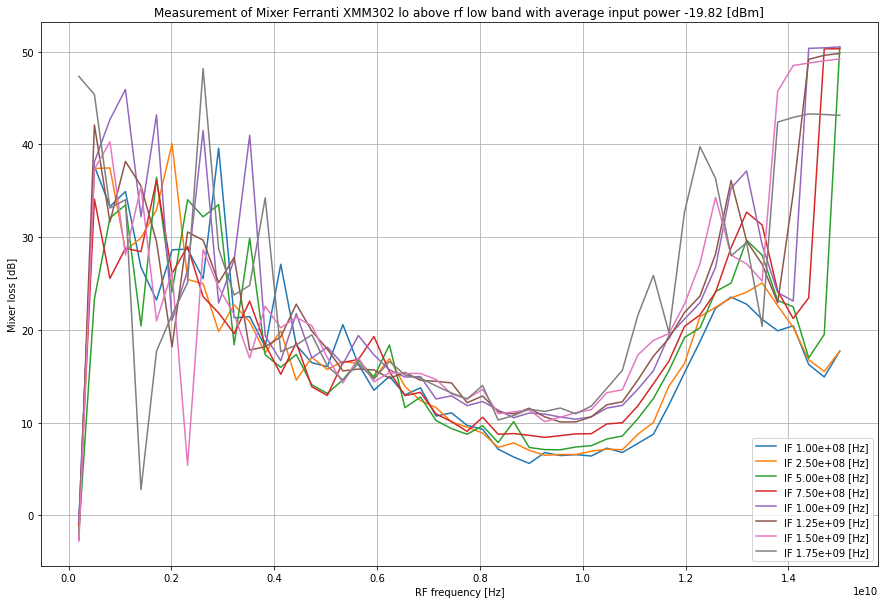

In [40]:
fifs=[100e6, 250e6, 500e6, 750e6, 1000e6, 1250e6, 1500e6, 1750e6]
frfs=np.linspace(200e6, 15e9, 50)
mixerCharacterization(fifs, frfs, 'Ferranti XMM302 lo above rf low band')

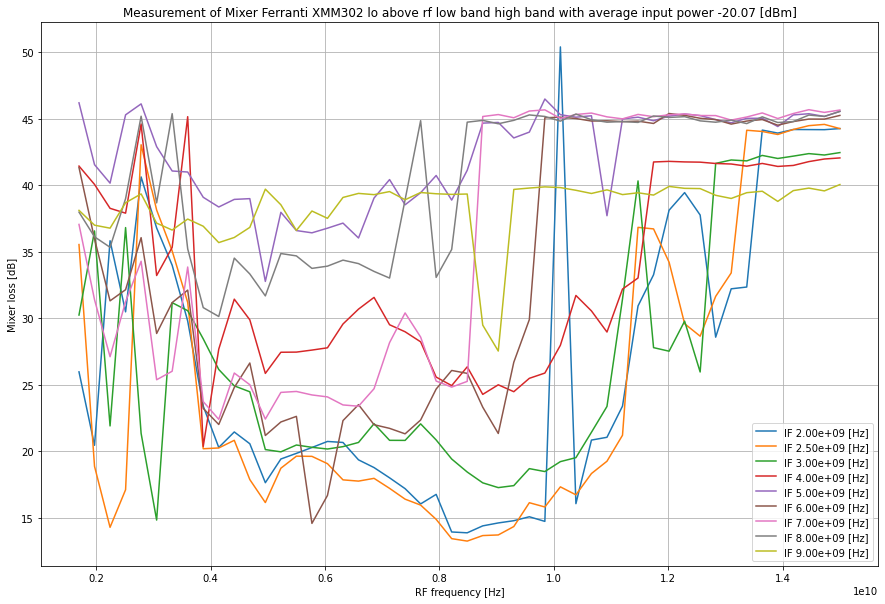

In [39]:
fifs=[2e9, 2.5e9, 3e9]
frfs=np.linspace(1700e6, 15e9, 50)
mixerCharacterization(fifs, frfs, 'Ferranti XMM302 lo above rf low band high band', tol=200e6)

### LO < RF

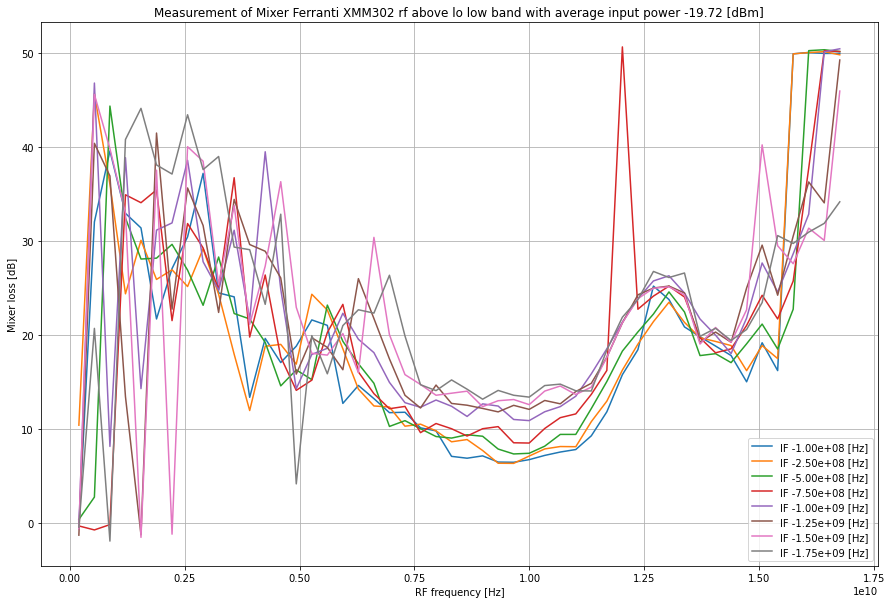

In [41]:
fifs=[-100e6, -250e6, -500e6, -750e6, -1000e6, -1250e6, -1500e6, -1750e6]
frfs=np.linspace(200e6, 15e9-np.min(fifs), 50)
mixerCharacterization(fifs, frfs, 'Ferranti XMM302 rf above lo low band')

## Watkins Johnson M80LCA

### LO > RF

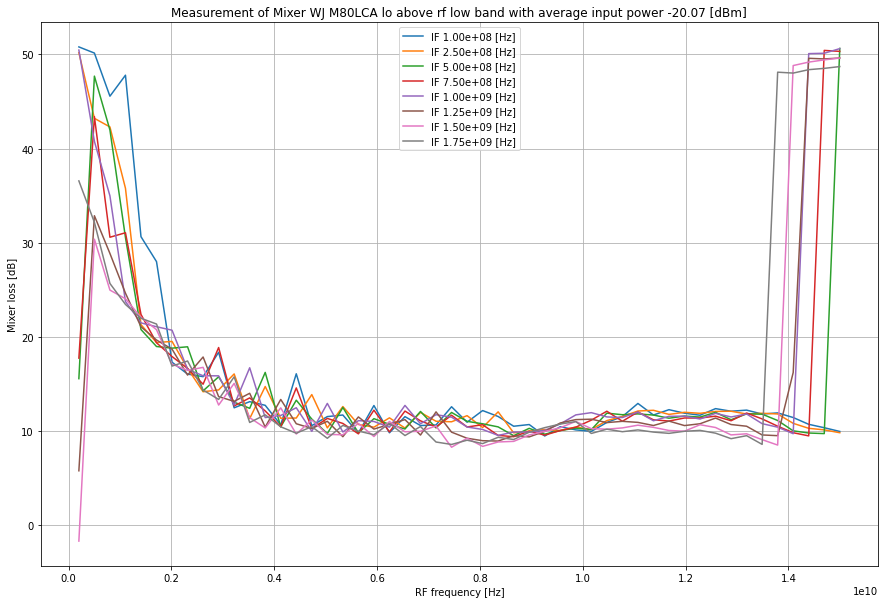

In [5]:
fifs=fifs=[100e6, 250e6, 500e6, 750e6, 1000e6, 1250e6, 1500e6, 1750e6]
frfs=np.linspace(200e6, 15e9, 50)
mixerCharacterization(fifs, frfs, 'WJ M80LCA lo above rf low band')

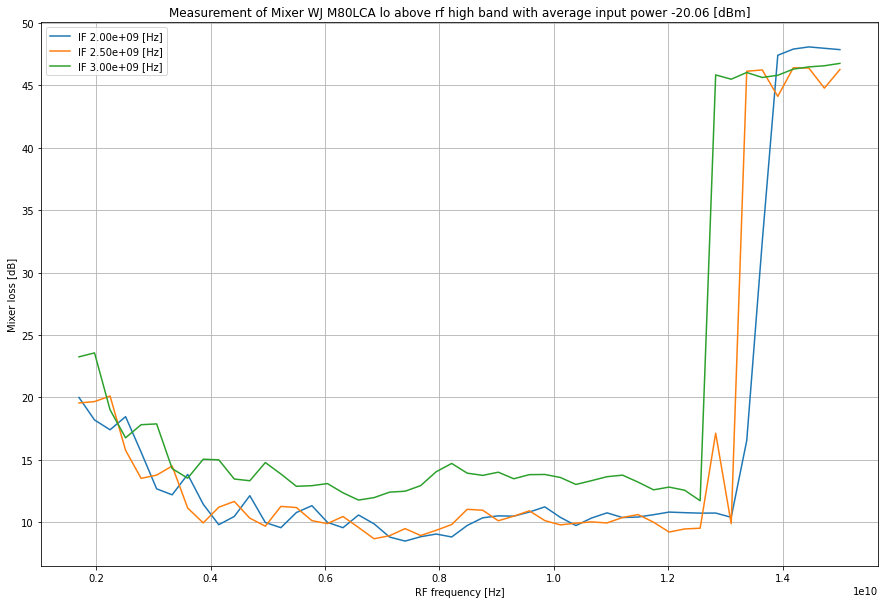

In [6]:
fifs=[2e9, 2.5e9, 3e9]
frfs=np.linspace(1700e6, 15e9, 50)
mixerCharacterization(fifs, frfs, 'WJ M80LCA lo above rf high band', tol=200e6)

### LO < RF

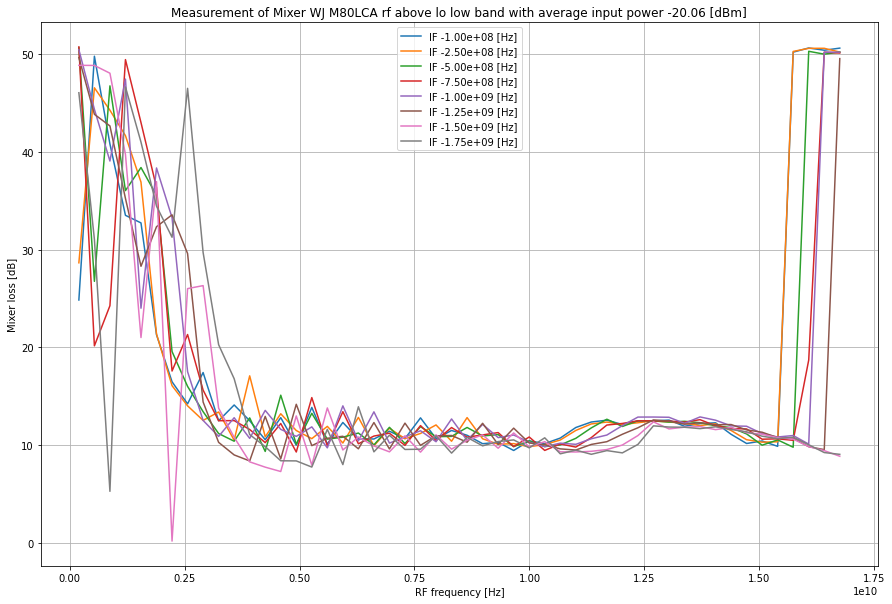

In [4]:
fifs=[-100e6, -250e6, -500e6, -750e6, -1000e6, -1250e6, -1500e6, -1750e6]
frfs=np.linspace(200e6, 15e9-np.min(fifs), 50)
mixerCharacterization(fifs, frfs, 'WJ M80LCA rf above lo low band')

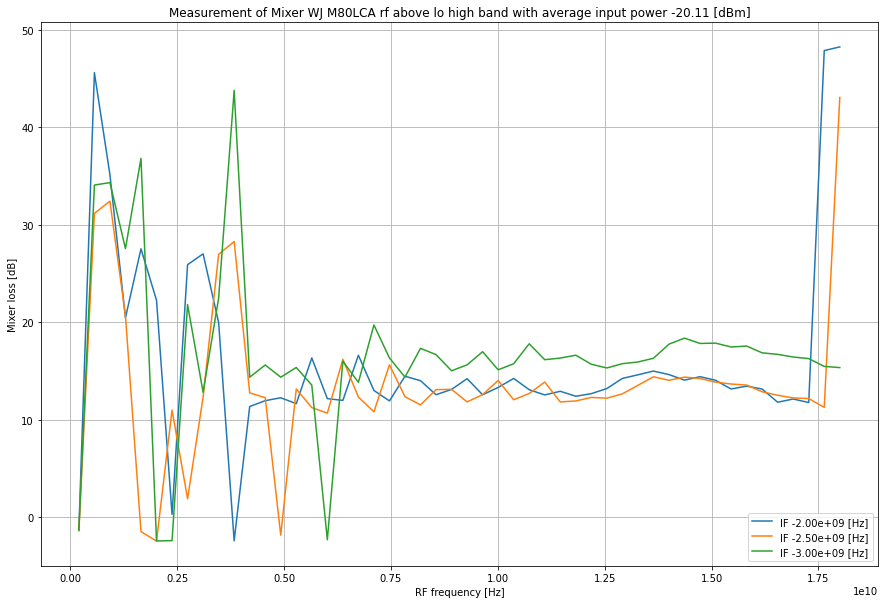

In [3]:
fifs=[-2e9, -2.5e9, -3e9]
frfs=np.linspace(200e6, 15e9-np.min(fifs), 50)
mixerCharacterization(fifs, frfs, 'WJ M80LCA rf above lo high band', tol=200e6)

## Microwave associates ML7520

### LO > RF

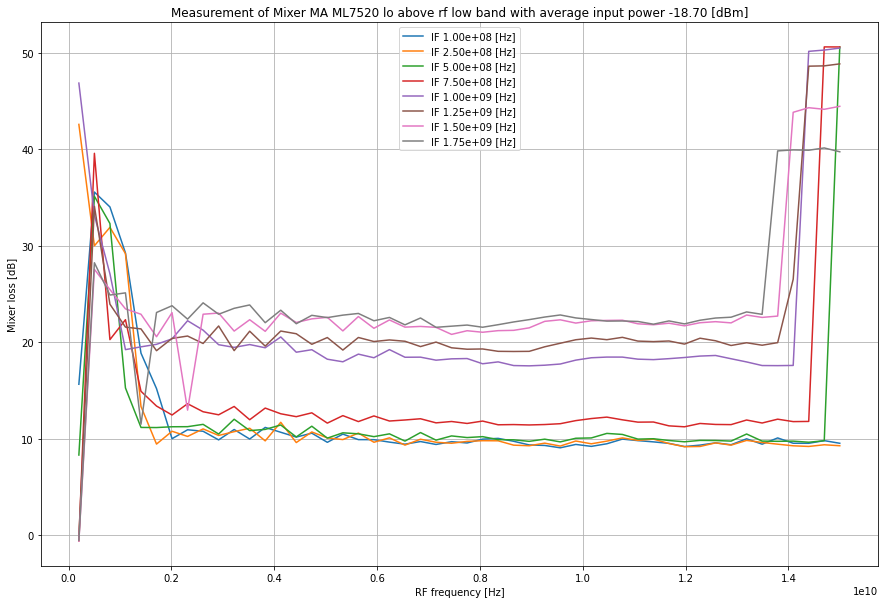

In [11]:
fifs=fifs=[100e6, 250e6, 500e6, 750e6, 1000e6, 1250e6, 1500e6, 1750e6]
frfs=np.linspace(200e6, 15e9, 50)
mixerCharacterization(fifs, frfs, 'MA ML7520 lo above rf low band')

### LO < RF

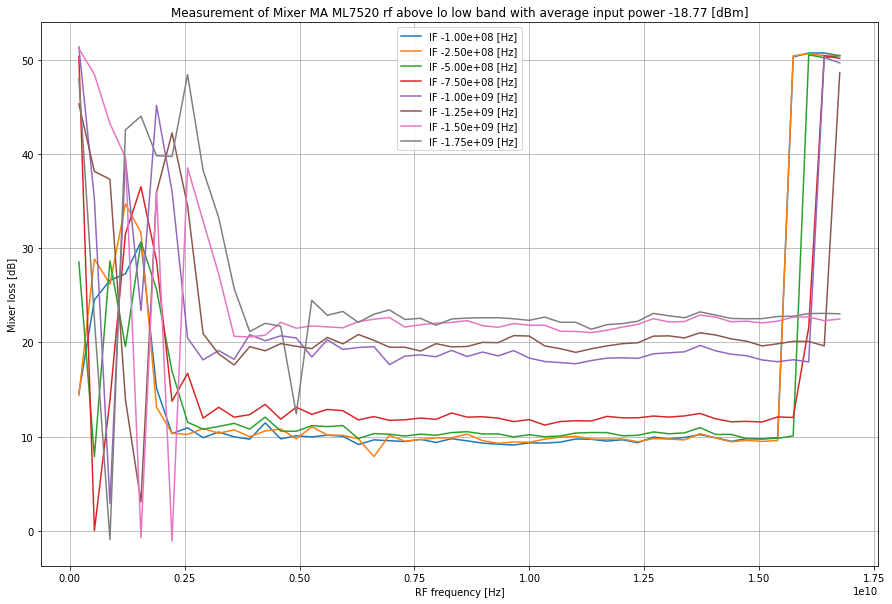

In [10]:
fifs=[-100e6, -250e6, -500e6, -750e6, -1000e6, -1250e6, -1500e6, -1750e6]
frfs=np.linspace(200e6, 15e9-np.min(fifs), 50)
mixerCharacterization(fifs, frfs, 'MA ML7520 rf above lo low band')

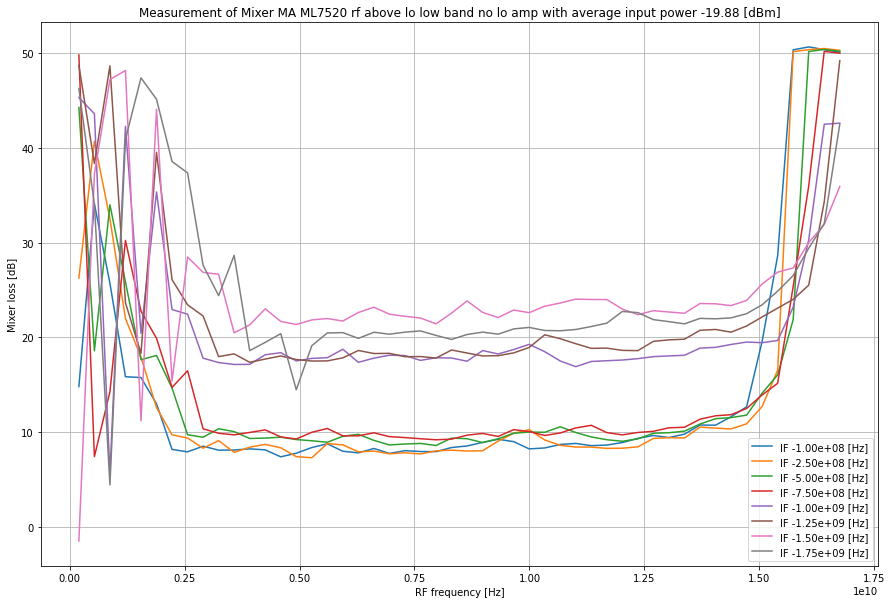

In [12]:
fifs=[-100e6, -250e6, -500e6, -750e6, -1000e6, -1250e6, -1500e6, -1750e6]
frfs=np.linspace(200e6, 15e9-np.min(fifs), 50)
mixerCharacterization(fifs, frfs, 'MA ML7520 rf above lo low band no lo amp')

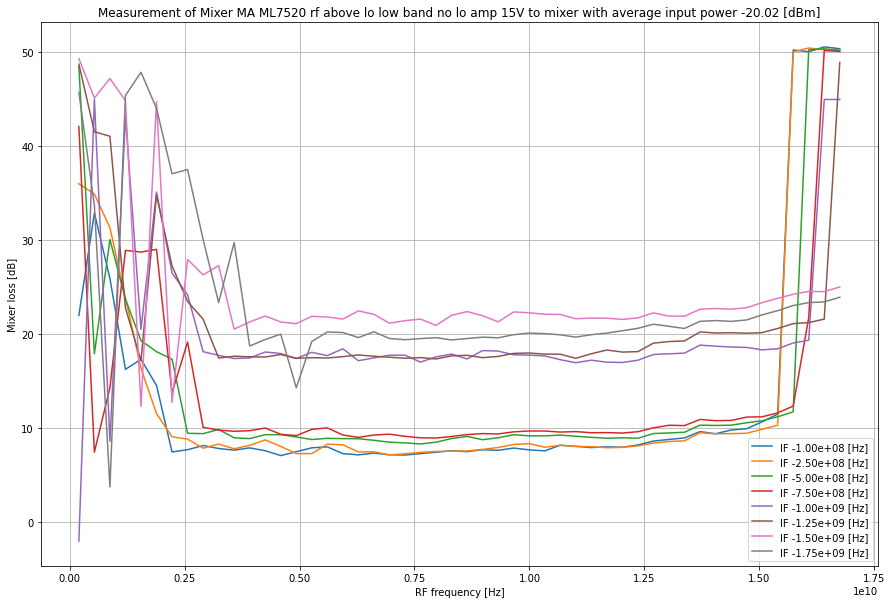

In [13]:
fifs=[-100e6, -250e6, -500e6, -750e6, -1000e6, -1250e6, -1500e6, -1750e6]
frfs=np.linspace(200e6, 15e9-np.min(fifs), 50)
mixerCharacterization(fifs, frfs, 'MA ML7520 rf above lo low band no lo amp 15V to mixer')

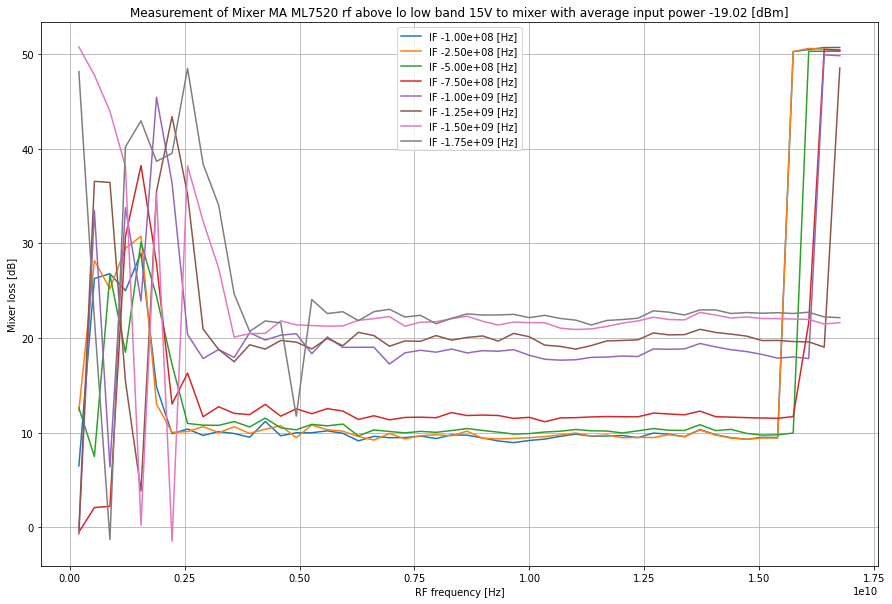

In [3]:
fifs=[-100e6, -250e6, -500e6, -750e6, -1000e6, -1250e6, -1500e6, -1750e6]
frfs=np.linspace(200e6, 15e9-np.min(fifs), 50)
mixerCharacterization(fifs, frfs, 'MA ML7520 rf above lo low band 15V to mixer')

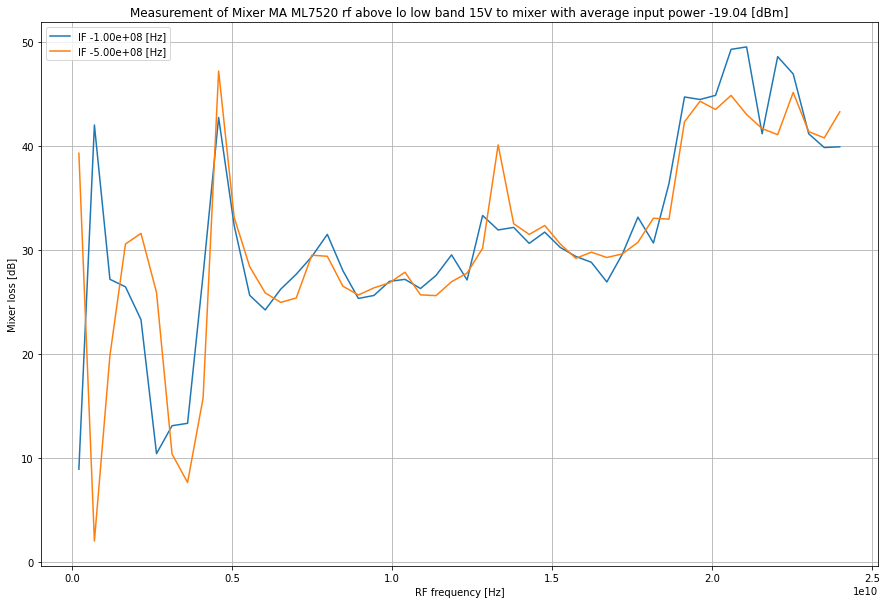

In [9]:
fifs=[-100e6, -250e6, -500e6, -750e6, -800e6, -900e6, -1000e6]
fifs=[-100e6,  -500e6]
frfs=np.linspace(200e6, 24e9, 50)
mixerCharacterization(fifs, frfs, 'MA ML7520 rf above lo low band 15V to mixer', harmonic=2)

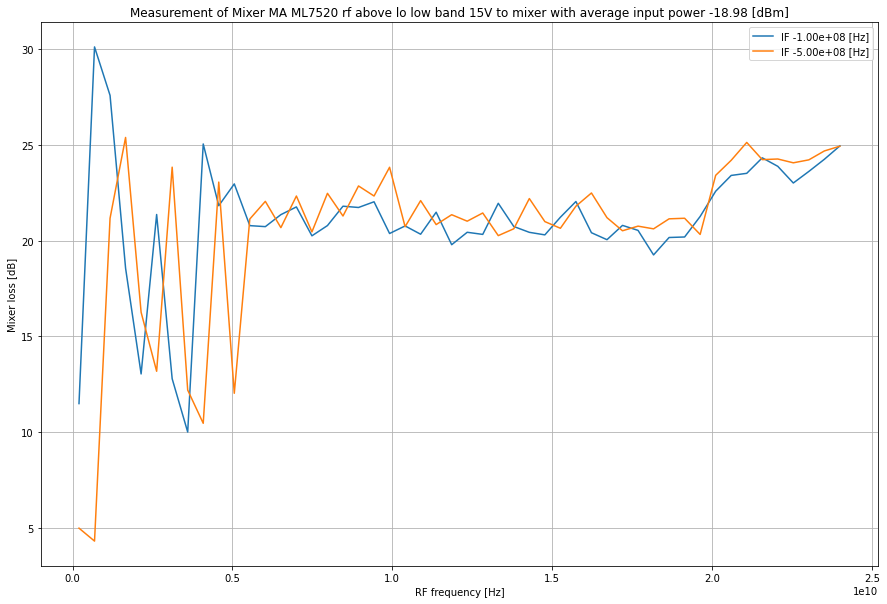

In [11]:
fifs=[-100e6, -250e6, -500e6, -750e6, -800e6, -900e6, -1000e6]
fifs=[-100e6,  -500e6]
frfs=np.linspace(200e6, 24e9, 50)
mixerCharacterization(fifs, frfs, 'MA ML7520 rf above lo low band 15V to mixer', harmonic=3)

## ANZAC AT020

### LO > RF

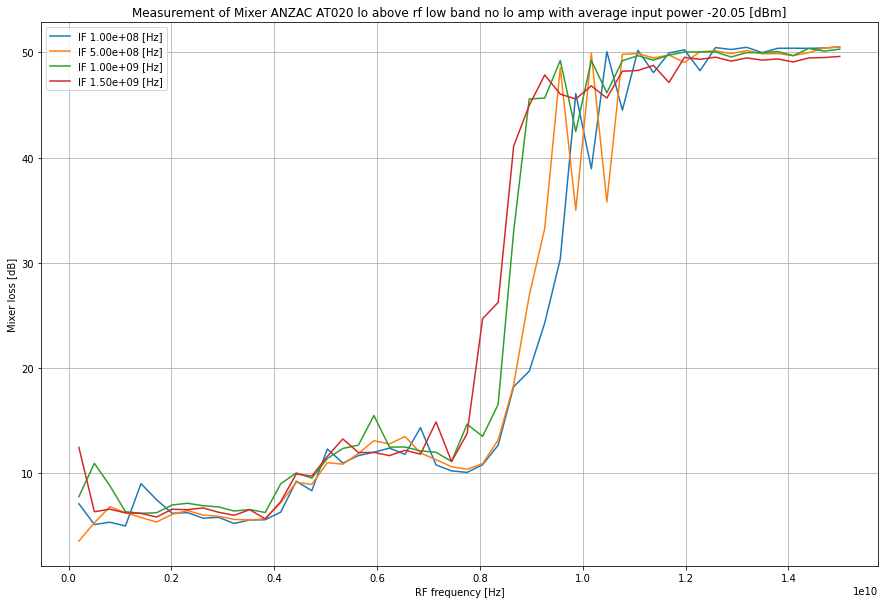

In [4]:
fifs=[100e6, 500e6, 1000e6, 1500e6]
frfs=np.linspace(200e6, 15e9, 50)
mixerCharacterization(fifs, frfs, 'ANZAC AT020 lo above rf low band no lo amp')

### LO < RF

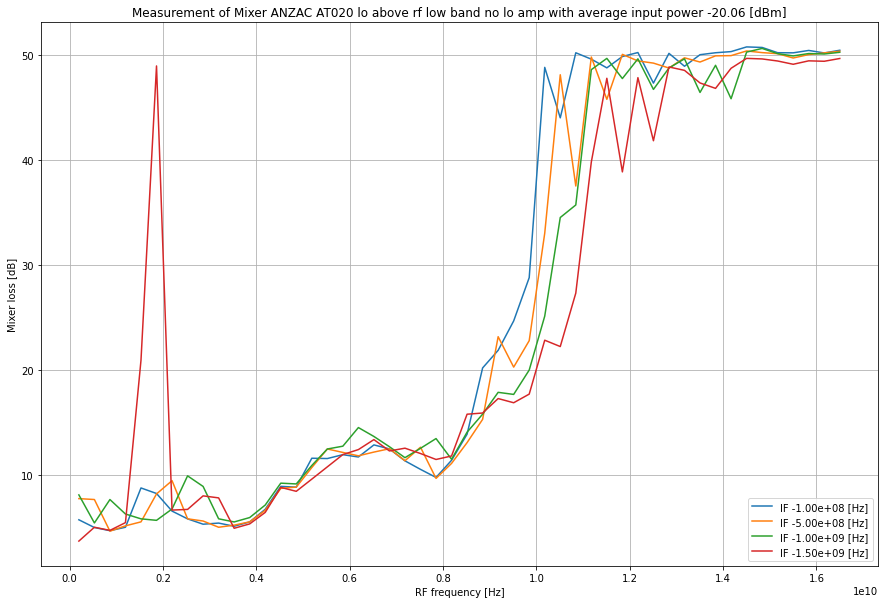

In [5]:
fifs=[-100e6, -500e6, -1000e6, -1500e6]
frfs=np.linspace(200e6, 15e9-np.min(fifs), 50)
mixerCharacterization(fifs, frfs, 'ANZAC AT020 lo above rf low band no lo amp')

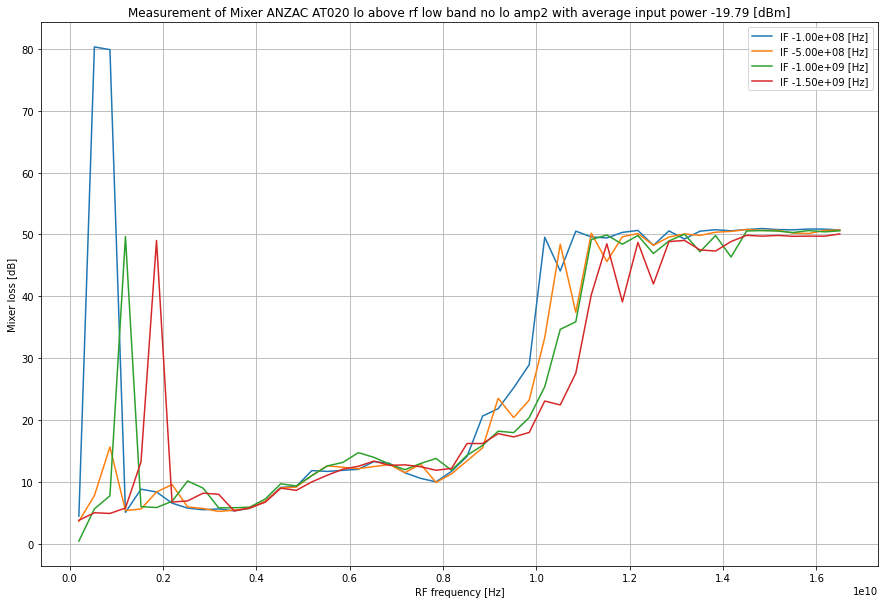

In [10]:
fifs=[-100e6, -500e6, -1000e6, -1500e6]
frfs=np.linspace(200e6, 15e9-np.min(fifs), 50)
mixerCharacterization(fifs, frfs, 'ANZAC AT020 lo above rf low band no lo amp2')

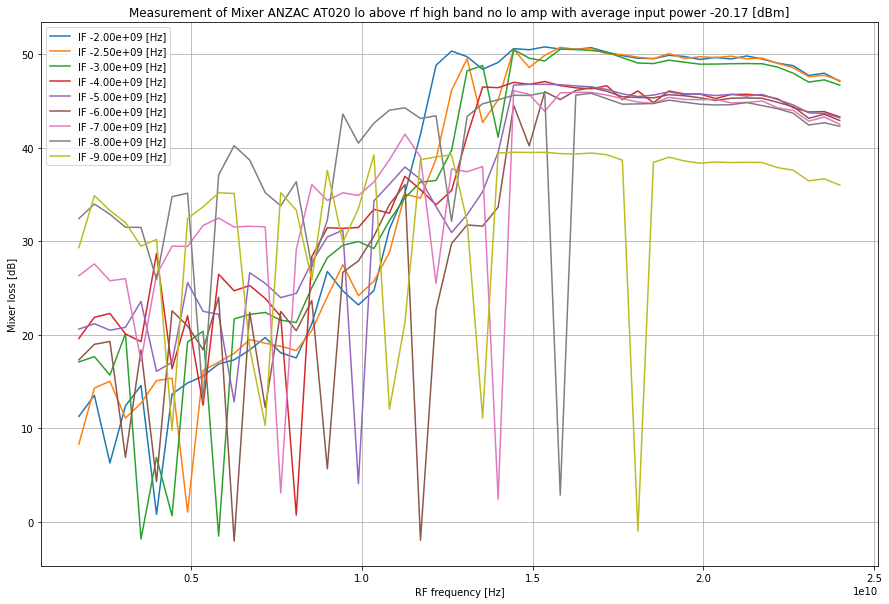

In [3]:
fifs=[-2e9, -2.5e9, -3e9, -4e9, -5e9, -6e9, -7e9, -8e9, -9e9]
frfs=np.linspace(1700e6, 15e9-np.min(fifs), 50)
mixerCharacterization(fifs, frfs, 'ANZAC AT020 lo above rf high band no lo amp', tol=200e6)

## ANAREN 73129

### LO > RF

### LO < RF

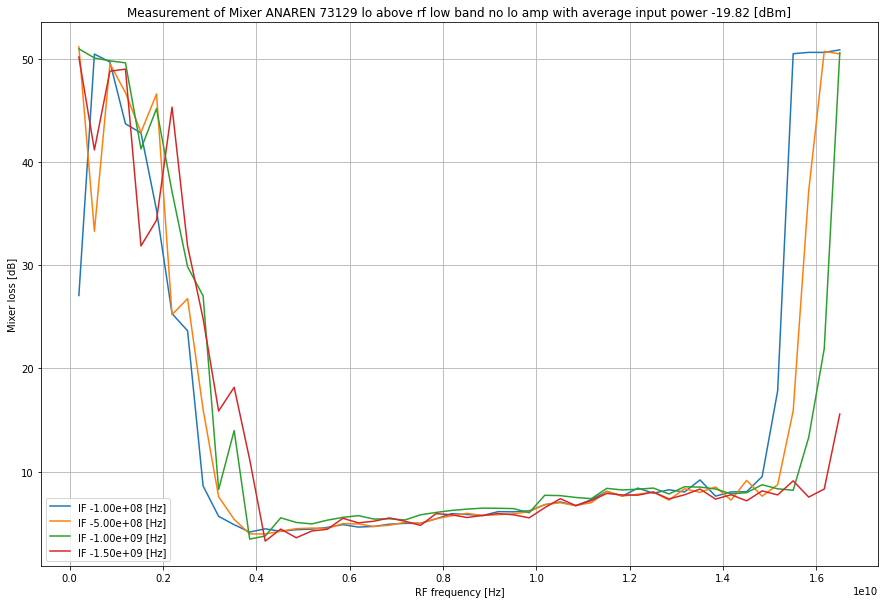

In [4]:
fifs=[-100e6, -500e6, -1000e6, -1500e6]
frfs=np.linspace(200e6, 15e9-np.min(fifs), 50)
mixerCharacterization(fifs, frfs, 'ANAREN 73129 lo above rf low band no lo amp')

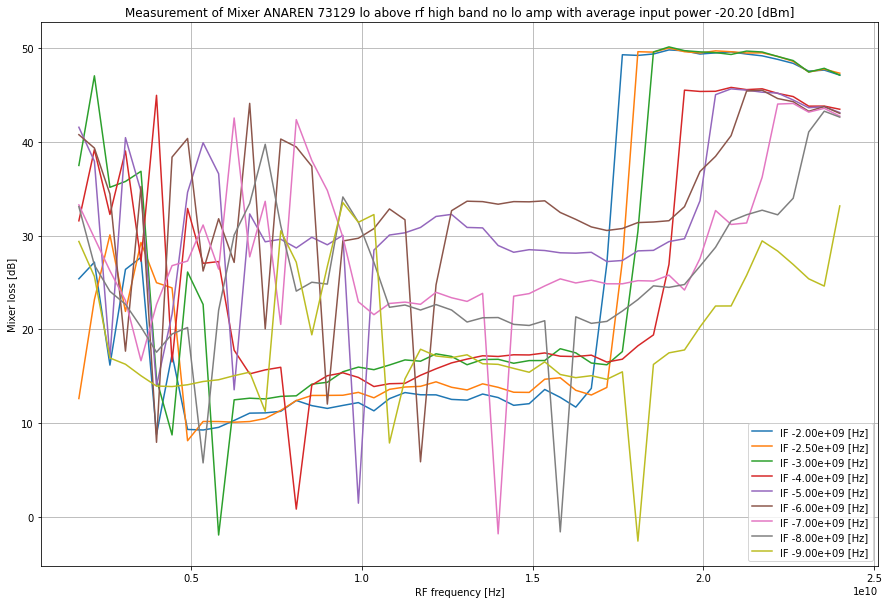

In [5]:
fifs=[-2e9, -2.5e9, -3e9, -4e9, -5e9, -6e9, -7e9, -8e9, -9e9]
frfs=np.linspace(1700e6, 15e9-np.min(fifs), 50)
mixerCharacterization(fifs, frfs, 'ANAREN 73129 lo above rf high band no lo amp', tol=200e6)

## HP10514A

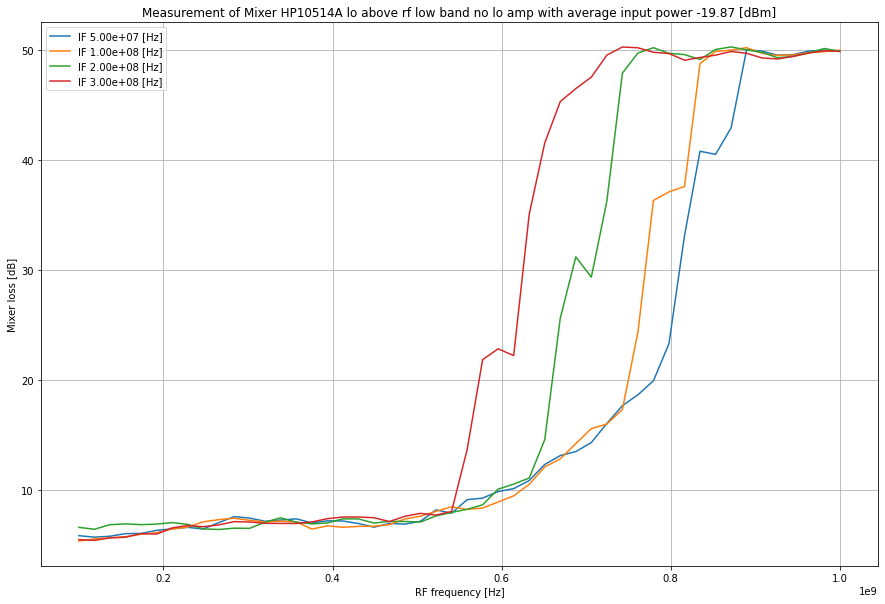

In [7]:
fifs=[50e6, 100e6, 200e6, 300e6]
frfs=np.linspace(100e6, 1e9, 50)
mixerCharacterization(fifs, frfs, 'HP10514A lo above rf low band no lo amp', tol=20e6)

## MINICIRCUS ZEM-4300-1

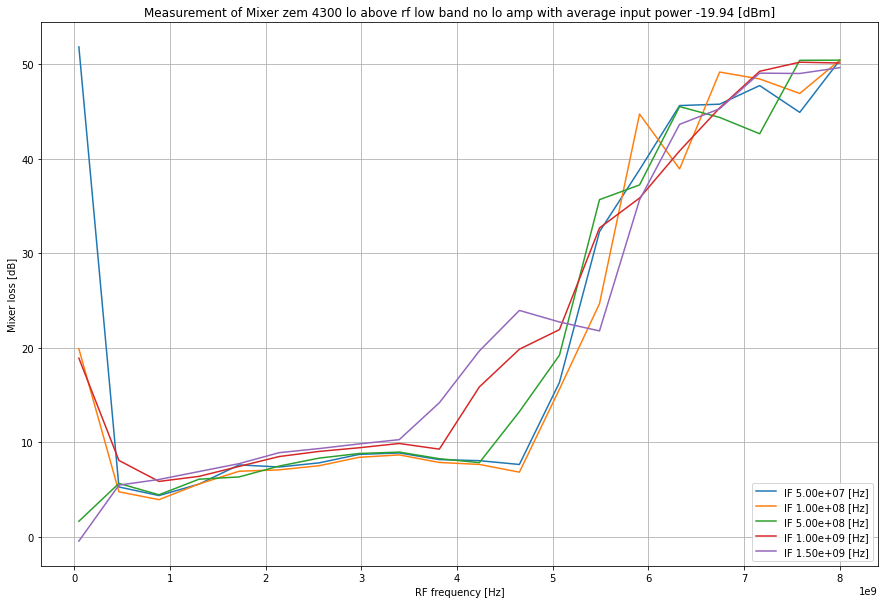

In [10]:
fifs=[50e6, 100e6, 500e6, 1000e6, 1500e6]#, 2e6, 3e6, 4e6, 5e6]
frfs=np.linspace(50e6, 8e9, 20)
mixerCharacterization(fifs, frfs, 'zem 4300 lo above rf low band no lo amp', tol=20e6)

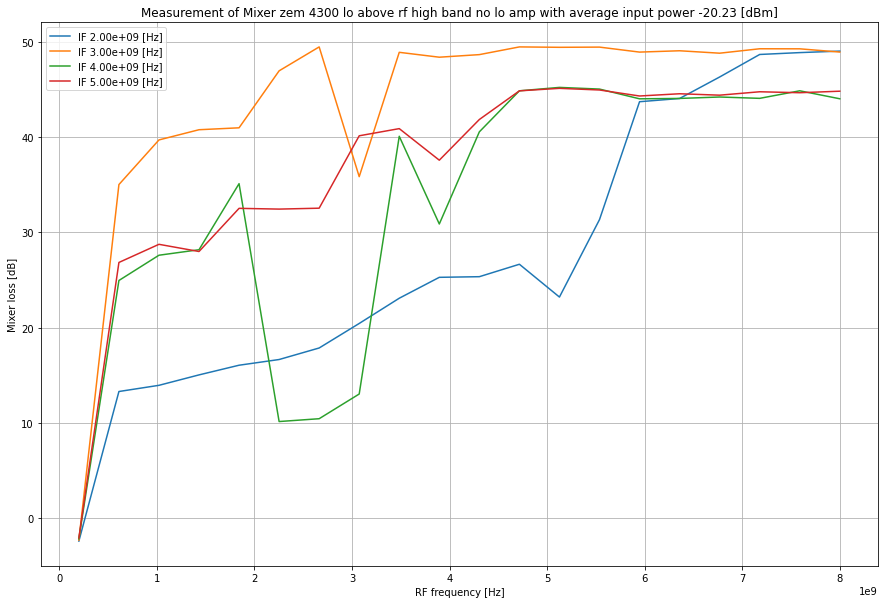

In [4]:
fifs=[2e9, 3e9, 4e9, 5e9]
frfs=np.linspace(200e6, 8e9, 20)
mixerCharacterization(fifs, frfs, 'zem 4300 lo above rf high band no lo amp', tol=200e6)